# How much of the trend is due to genre composition effects?


In [1]:
import csv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('loc_results.tsv', sep = '\t')
data.head()

,genre,firstdoc,firstdate,matchdate,datediff,meandate,ingenredist,fullrandomdist,othergenredist,fullrandomdiff,othergenrediff
0,western stories,mdp.39015047667285,1987,1981,6,1984.0,0.216592,0.137350,0.214032,-0.079242,-0.002559
1,western stories,nyp.33433075812374,1879,1885,6,1882.0,0.247743,0.186961,0.186892,-0.060782,-0.060851
2,short stories,pst.000044138431,1999,2005,6,2002.0,0.103688,0.103391,0.107809,-0.000296,0.004122
3,science fiction,dul1.ark+=13960=t1fj34z1f,1871,1877,6,1874.0,0.090927,0.198419,0.166309,0.107492,0.075381
4,fairy tales,mdp.39015062476109,1958,1964,6,1961.0,0.182881,0.185927,0.165181,0.003047,-0.017700


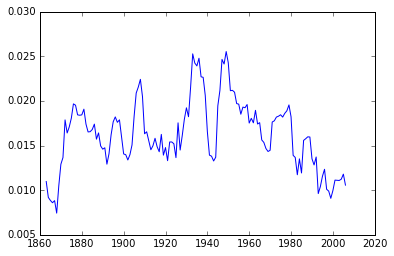

In [3]:
dates = []
smoothedmain = []
for yr in range(1863, 2007):
    sevenyear = data.loc[(data.meandate >= yr - 3) & (data.meandate <= yr + 3), 'othergenrediff']
    sevenyearmedian = np.median(sevenyear)
    dates.append(yr)
    smoothedmain.append(sevenyearmedian)

plt.plot(dates, smoothedmain)
plt.show()

### Is this trend due to changes in individual genres, or due to change in the genre-composition of the corpus?

To find out we can calculate the mean diff for each genre, and then plot the trend we would see if genres consistently mapped to that same diff across the timeline.

In [4]:
genremeans = dict()
allgenrenames = list(set(data.genre))

for g in allgenrenames:
    averagediff = np.mean(data.loc[data.genre == g, 'othergenrediff'])
    genremeans[g] = averagediff

genremeans

{'adventure stories': 0.006785053266187786,
 'autobiography': 0.014292739114020925,
 'domestic fiction': 0.0215976076177158,
 'fairy tales': 0.0261356799652118,
 'folklore': 0.005960965032739693,
 'ghost stories': 0.02544661139562905,
 'history': 0.00632630710693261,
 'humor': 0.01795600957335065,
 'imaginary voyages': -0.023530554408423356,
 'legends': 0.008206197705951816,
 'love stories': 0.027926310059586713,
 'mystery and detective fiction': 0.025245483431855956,
 'novel': 0.008832520118876669,
 'psychological fiction': 0.007808501346547562,
 'science fiction': 0.024789292727813085,
 'sea stories': 0.017744678478216272,
 'short stories': 0.02863552975956743,
 'tales': 0.014123981675893347,
 'war stories': 0.008895430729018538,
 'western stories': 0.012311101364998635}

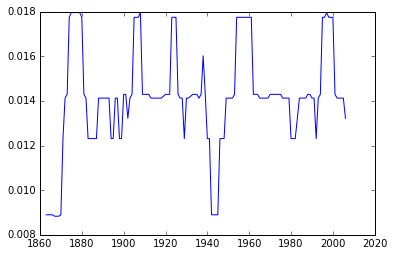

In [5]:
def map2mean(agenre):
    global genremeans
    return genremeans[agenre]

def assume_means(agenrevector):
    return np.median(agenrevector.map(map2mean))

dates = []
medianwithcompositiononly = []
for yr in range(1863, 2007):
    sevenyear = data.loc[(data.meandate >= yr - 3) & (data.meandate <= yr + 3), 'genre']
    sevenyearmedian = assume_means(sevenyear)
    dates.append(yr)
    medianwithcompositiononly.append(sevenyearmedian)

plt.plot(dates, medianwithcompositiononly)
plt.show()  

Changes due to composition alone don't reveal much of a trend.

In fact, the trend remains if we look only at *deviations* from the mean for each genre.

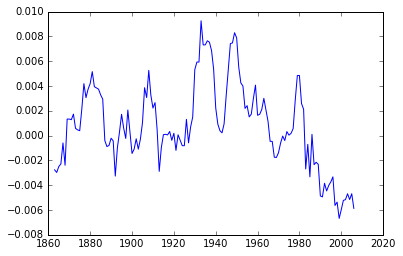

In [6]:
dates = []
diffsfromcomposition = []
for yr in range(1863, 2007):
    actualdiffs = data.loc[(data.meandate >= yr - 3) & (data.meandate <= yr + 3), 'othergenrediff']
    compositiondiffs = data.loc[(data.meandate >= yr - 3) & (data.meandate <= yr + 3), 'genre'].map(map2mean)
    exceedscomposition = np.median(actualdiffs - compositiondiffs)
    dates.append(yr)
    diffsfromcomposition.append(exceedscomposition)

plt.plot(dates, diffsfromcomposition)
plt.show()  

### What about the actual composition of the collection?

In [7]:
meta = pd.read_csv('/Users/tunder/Dropbox/python/noveltmmeta/metadata/titlemeta.tsv', sep = '\t', low_memory = False)

categories = dict()

with open('genre_groups_for_20c_exp.tsv', encoding = 'utf-8') as f:
    reader = csv.reader(f, delimiter = '\t')
    for fields in reader:
        categories[fields[0]] = set(fields)

genrecompbydate = dict()       
        
for yr in range(1860, 2010):
    if yr % 10 == 1:
        print(yr)
    thesetitles = meta.loc[meta.latestcomp == yr, : ]
    genrelistforyear = []
    for idx, row in thesetitles.iterrows():
        if not pd.isnull(row.subjects):
            headings = row.subjects.lower().split('|')
        else:
            headings = []
        if not pd.isnull(row.genres):
            headings.extend(row.genres.lower().split('|'))
        genres4row = set()
        for h in headings:
            for label, matchingcats in categories.items():
                if h in matchingcats:
                    genres4row.add(label)
        genrelistforyear.extend(genres4row)
    genrecompbydate[yr] = genrelistforyear
  

1861
1871
1881
1891
1901
1911
1921
1931
1941
1951
1961
1971
1981
1991
2001


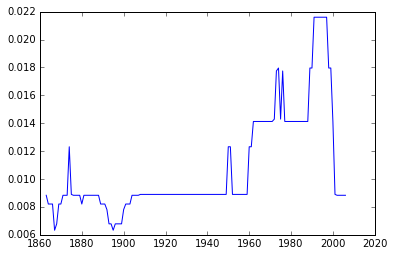

In [8]:
dates = []
realcomposition = []

for yr in range(1863, 2007):
    allgenres = []
    for year in range(yr-3, yr+4):
        allgenres.extend(genrecompbydate[year])
    sevenyearmedian = assume_means(pd.Series(allgenres))
    dates.append(yr)
    realcomposition.append(sevenyearmedian)

plt.plot(dates, realcomposition)
plt.show()  

**Conclusion**: In the last sixty years, our Hathi dataset has a lot *more* of the genres that tend to be very coherent. That is, a lot more of the genres that tend to have low in-genre distance or high other-genre distance (across the timeline). But of course that's not actually constant across the timeline.

In [9]:
meansbyyear = dict()
allgenrenames = list(set(data.genre))
for yr in range(1860,2020):
    thisyear = data.loc[data.meandate == yr, : ]
    thisyeargenrenames = list(set(thisyear.genre))
    meansbyyear[yr] = dict()
    for g in thisyeargenrenames:
        averagediff = np.mean(thisyear.loc[data.genre == g, 'othergenrediff'])
        meansbyyear[yr][g] = averagediff
    for g in allgenrenames:
        if yr > 1860 and g not in meansbyyear[yr] and g in meansbyyear[yr-1]:
            meansbyyear[yr][g] = meansbyyear[yr-1][g]
    


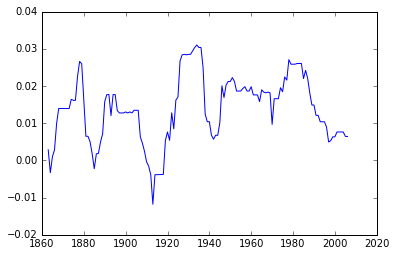

327


In [10]:
def meansforthisyear(genrevector, dictforyear):
    global errors
    meansfound = []
    for g in genrevector:
        if g in dictforyear:
            meansfound.append(dictforyear[g])
        else:
            errors += 1
    return meansfound

dates = []
hathimedians = []
errors = 0

for yr in range(1863, 2007):
    allmeans = []
    for year in range(yr-3, yr+4):
        allmeans.extend(meansforthisyear(genrecompbydate[year], meansbyyear[year]))
    sevenyearmedian = np.median(allmeans)
    dates.append(yr)
    hathimedians.append(sevenyearmedian)

plt.plot(dates, hathimedians)
plt.show() 
print(errors)

That might be the best picture of what's really going on in the collection? With the proviso that other-genre distances would *also* change if we had a sample of genres that more closely matched the actual distribution in Hathi. So in some ways the Kirkus sample might be a better picture. In any case, we're on pretty safe ground in saying that genre differences get bigger in the middle of the 20c and seem to have declined recently.

### What are the actual differences in genre composition?

The answer is that the late 19c is dominated by historical fiction.

Genre composition gets more diverse in the 20c, especially after 1960. In the early-mid 20c war stories are prominent.

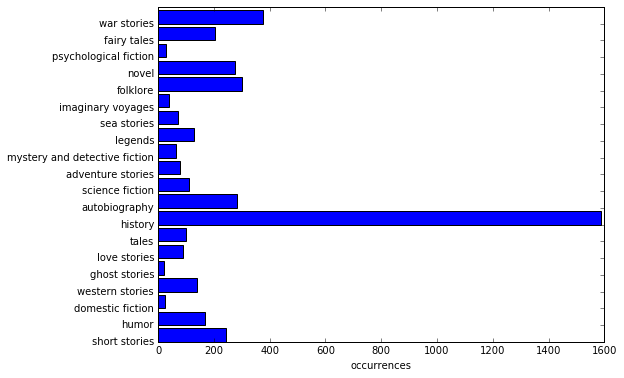

In [18]:
late19c = []
for yr in range(1860, 1910):
    late19c.extend(genrecompbydate[yr])

late19cgenres = list(set(late19c))
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
y_pos = np.arange(len(late19cgenres))
x_pos = []
for g in late19cgenres:
    x_pos.append(late19c.count(g))

ax.barh(y_pos, x_pos)
ax.set_yticks(y_pos)
ax.set_yticklabels(late19cgenres)
ax.set_xlabel('occurrences')
plt.show()

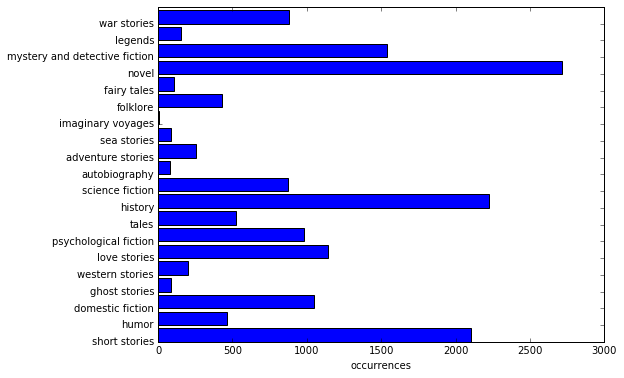

In [20]:
late20c = []
for yr in range(1960, 2010):
    late20c.extend(genrecompbydate[yr])

late20cgenres = list(set(late20c))
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
y_pos = np.arange(len(late20cgenres))
x_pos = []
for g in late20cgenres:
    x_pos.append(late20c.count(g))

ax.barh(y_pos, x_pos)
ax.set_yticks(y_pos)
ax.set_yticklabels(late20cgenres)
ax.set_xlabel('occurrences')
plt.show()

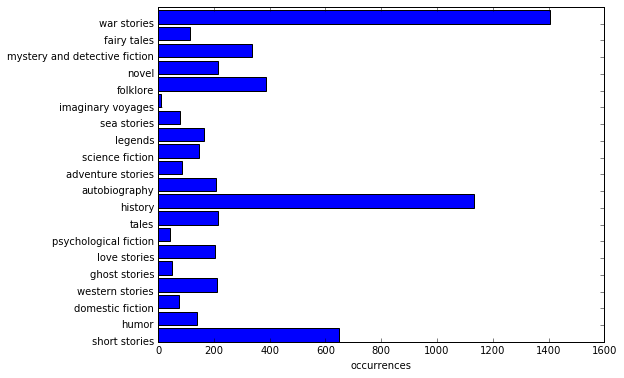

In [21]:
mid20c = []
for yr in range(1910, 1960):
    mid20c.extend(genrecompbydate[yr])

mid20cgenres = list(set(mid20c))
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
y_pos = np.arange(len(mid20cgenres))
x_pos = []
for g in mid20cgenres:
    x_pos.append(mid20c.count(g))

ax.barh(y_pos, x_pos)
ax.set_yticks(y_pos)
ax.set_yticklabels(mid20cgenres)
ax.set_xlabel('occurrences')
plt.show()